In [127]:
%matplotlib inline

import sys
import wave

from IPython.display import display, Audio
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pyaudio
import scipy
from scipy.io import wavfile
from scipy.signal import istft, stft

from noise_reduction.utils import listen, record

In [2]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 5

# Record

In [66]:
with wave.open('background_noise.wav', 'wb') as wf:
    p = pyaudio.PyAudio()
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)

    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True)

    print('Recording...')
    for _ in range(0, RATE // CHUNK * RECORD_SECONDS):
        wf.writeframes(stream.read(CHUNK))
    print('Done')

    stream.close()
    p.terminate()

Recording...
Done


In [67]:
with wave.open('talking.wav', 'wb') as wf:
    p = pyaudio.PyAudio()
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)

    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True)

    print('Recording...')
    for _ in range(0, RATE // CHUNK * RECORD_SECONDS):
        wf.writeframes(stream.read(CHUNK))
    print('Done')

    stream.close()
    p.terminate()

Recording...
Done


In [69]:
with wave.open('talking.wav', 'rb') as wf:
    # Instantiate PyAudio and initialize PortAudio system resources (1)
    p = pyaudio.PyAudio()

    # Open stream (2)
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)

    # Play samples from the wave file (3)
    while len(data := wf.readframes(CHUNK)):  # Requires Python 3.8+ for :=
        stream.write(data)

    # Close stream (4)
    stream.close()

    # Release PortAudio system resources (5)
    p.terminate()

# Spectral Subtraction

In [70]:
sample_rate, audio_data = wavfile.read('background_noise.wav')

In [71]:
audio_data.shape

(220160,)

In [72]:
sample_rate

44100

In [73]:
f, t, Zxx = stft(audio_data, fs=sample_rate, nperseg=512, noverlap=256)

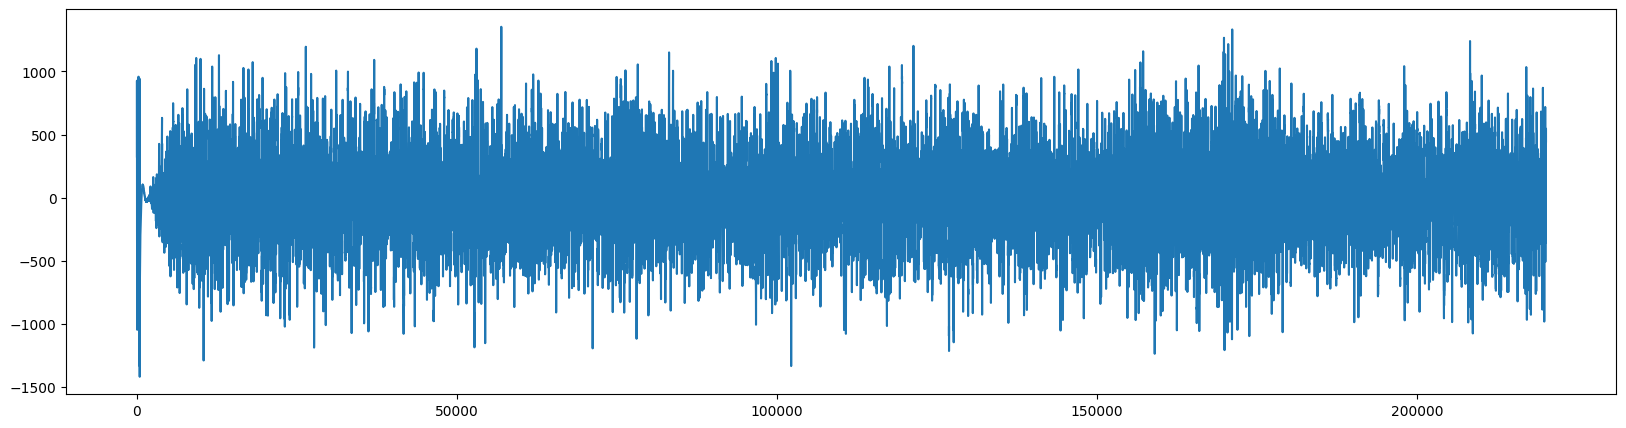

In [74]:
plt.figure(figsize=(20,5));
plt.plot(audio_data);

#### Short Fourier Transform of Audio Data

/Users/scottcronin/.pyenv/versions/3.11.2/envs/noise_reduction/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/scottcronin/.pyenv/versions/3.11.2/envs/noise_reduction/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


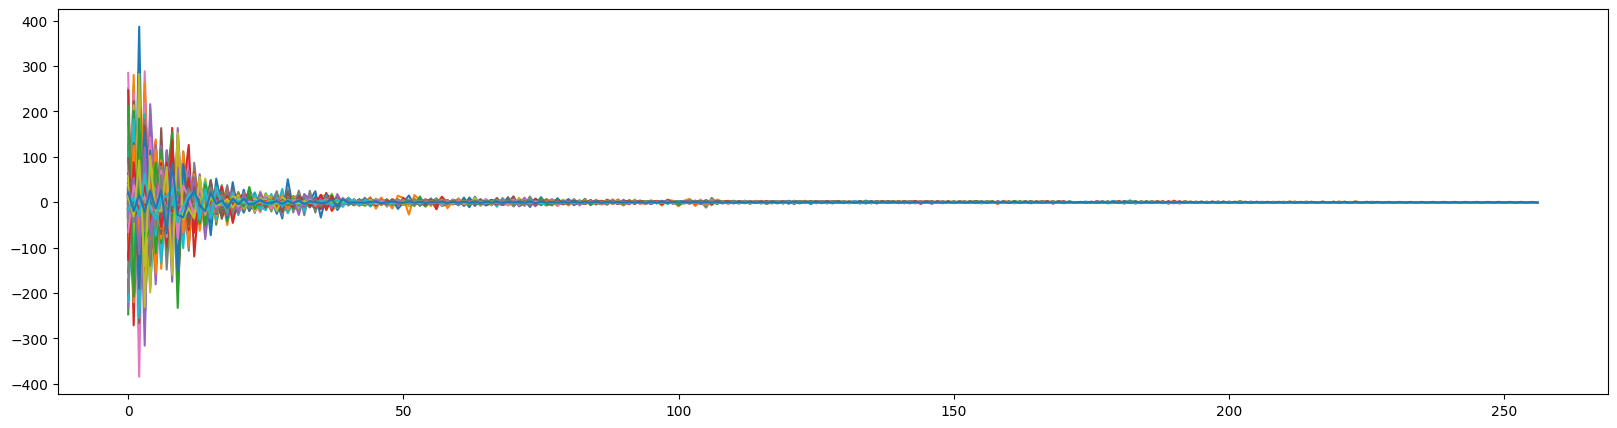

In [75]:
plt.figure(figsize=(20,5));
plt.plot(Zxx);

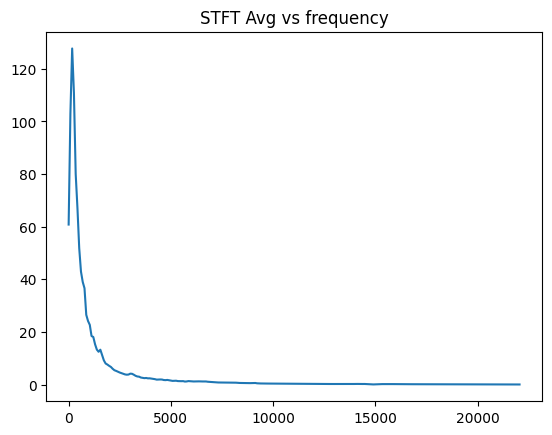

In [77]:
noise_spectrum = np.mean(np.abs(Zxx), axis=1)
plt.plot(f, noise_spectrum)
plt.title('STFT Avg vs frequency');

In [86]:
sample_rate, audio_data = wavfile.read('talking.wav')
f, t, Zxx = stft(audio_data, fs=sample_rate, nperseg=512, noverlap=256)

In [89]:
t.shape

(861,)

In [91]:
Zxx.shape

(257, 861)

In [79]:
SNR = 5  # Desired signal-to-noise ratio
magnitude_spectrogram = np.abs(Zxx)
magnitude_spectrogram.shape

(257, 861)

In [80]:
enhanced_spectrogram = magnitude_spectrogram - SNR * noise_spectrum[:, np.newaxis]
enhanced_spectrogram

array([[-2.75952820e+02, -2.37829910e+02, -2.03856995e+02, ...,
        -2.27727844e+02, -2.64415466e+02, -2.94412781e+02],
       [-4.68462677e+02, -3.81215973e+02, -4.25142639e+02, ...,
        -3.57921997e+02, -4.78789520e+02, -4.52633667e+02],
       [-5.80735596e+02, -4.31206818e+02, -5.36784363e+02, ...,
        -4.82770020e+02, -5.41644104e+02, -5.30452515e+02],
       ...,
       [-1.00356951e-01, -9.32817981e-02, -1.16985388e-01, ...,
        -9.84313488e-02, -7.58369714e-02,  1.90932006e-02],
       [-1.04371384e-01, -7.94307813e-02, -1.10167705e-01, ...,
        -9.83679146e-02, -8.42993855e-02,  2.44854391e-02],
       [-9.34933126e-02, -6.18290342e-02, -9.07799900e-02, ...,
        -1.06194913e-01, -1.12327673e-01,  2.47269496e-02]], dtype=float32)

In [81]:
enhanced_spectrogram = np.maximum(enhanced_spectrogram, 0)  # Ensure non-negativity

In [82]:
_, enhanced_audio_data = istft(enhanced_spectrogram, fs=sample_rate, nperseg=512, noverlap=256)

In [83]:
wavfile.write("talking_enhanced.wav", sample_rate, np.int16(enhanced_audio_data))

In [84]:
with wave.open('talking.wav', 'rb') as wf:
    # Instantiate PyAudio and initialize PortAudio system resources (1)
    p = pyaudio.PyAudio()

    # Open stream (2)
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)

    # Play samples from the wave file (3)
    while len(data := wf.readframes(CHUNK)):  # Requires Python 3.8+ for :=
        stream.write(data)

    # Close stream (4)
    stream.close()

    # Release PortAudio system resources (5)
    p.terminate()

In [85]:
with wave.open('talking_enhanced.wav', 'rb') as wf:
    # Instantiate PyAudio and initialize PortAudio system resources (1)
    p = pyaudio.PyAudio()

    # Open stream (2)
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)

    # Play samples from the wave file (3)
    while len(data := wf.readframes(CHUNK)):  # Requires Python 3.8+ for :=
        stream.write(data)

    # Close stream (4)
    stream.close()

    # Release PortAudio system resources (5)
    p.terminate()

# Try with Noise Reduce Library

In [3]:
import noisereduce as nr

In [20]:
rate, data = wavfile.read("talking.wav")

# perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write("talking_filtered.wav", rate, reduced_noise)

In [22]:
with wave.open('talking_filtered.wav', 'rb') as wf:
    # Instantiate PyAudio and initialize PortAudio system resources (1)
    p = pyaudio.PyAudio()

    # Open stream (2)
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)

    # Play samples from the wave file (3)
    while len(data := wf.readframes(CHUNK)):  # Requires Python 3.8+ for :=
        stream.write(data)

    # Close stream (4)
    stream.close()

    # Release PortAudio system resources (5)
    p.terminate()

# Latency Calculations

In [95]:
sample_rate, audio_data = wavfile.read('talking.wav')
audio_data.shape

(220160,)

In [98]:
chunk = audio_data[:1024]
chunk.shape

(1024,)

In [103]:
def test_algo_time(chunk):
    _, _, Zxx = stft(chunk, fs=sample_rate, nperseg=512, noverlap=256)
    enhanced = np.abs(Zxx) - 5 * noise_spectrum[:, np.newaxis]
    _, enhanced_audio_data = istft(enhanced, fs=sample_rate, nperseg=512, noverlap=256)
    return enhanced_audio_data

In [104]:
%%timeit
test_algo_time(chunk)

102 µs ± 209 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [109]:
audio_data.size / CHUNK

215.0

In [112]:
for i in range(0, audio_data.size // CHUNK, CHUNK):
    print(i)

0


In [124]:
%%timeit
audios = []
for i in range(0, audio_data.size, CHUNK):
    audios.append(test_algo_time(audio_data[i:i+CHUNK]))
audios = np.concatenate(audios).astype(np.int16)

22.3 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [125]:
wavfile.write("chunked_filtered.wav", RATE, audios)
# wavfile.write("talking_enhanced.wav", sample_rate, np.int16(enhanced_audio_data))

In [126]:
with wave.open('chunked_filtered.wav', 'rb') as wf:
    # Instantiate PyAudio and initialize PortAudio system resources (1)
    p = pyaudio.PyAudio()

    # Open stream (2)
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)

    # Play samples from the wave file (3)
    while len(data := wf.readframes(CHUNK)):  # Requires Python 3.8+ for :=
        stream.write(data)

    # Close stream (4)
    stream.close()

    # Release PortAudio system resources (5)
    p.terminate()

Error: unknown format: 3

# Algo runs in 0.1 ms per chunk